$(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\frac{\partial u}{\partial t} + \textbf{a}(\textbf{x}, t)\cdot\nabla u = 0$$

initial condition

$$u(\textbf{x},t=0)=u_0(\textbf{x})$$

$\textbf{x}\in\partial\Omega_I$ inflow boundary condition

$$u = u_I$$

time discretization

$$\frac{u^{n+1} - u^n}{\Delta t} + \textbf{a}^n\cdot\nabla\mathcal{D}(u) = 0$$

variational formulation

$$\int_\Omega\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t} + v\,\textbf{a}^n\cdot\nabla\mathcal{D}(u)=0  \quad\forall v\in V$$

In [ ]:
import numpy as np
from ufl import Form, dx, inner, grad, TestFunction

from lucifex.mesh import interval_mesh
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.fdm import DT, CN, AB2, BE, FE, FiniteDifference, FunctionSeries, ConstantSeries
from lucifex.solver import ibvp_solver, eval_solver , BoundaryConditions
from lucifex.sim import integrate, Simulation
from lucifex.viz import plot_line


def advection(
    u: FunctionSeries,
    dt: Constant,
    a: Function | Constant,
    Dfdm: FiniteDifference,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    Ft = v * DT(u, dt) * dx
    Fa = v * inner(a, grad(Dfdm(u))) * dx
    return Ft, Fa

def velocity(
    t: Constant,
    eps: float,
) -> tuple[float]:
    return (1.0 + eps * float(t), )

### $d=1$

$$\Omega = [0, L_x]$$

$$\textbf{a}(t)=(1 + \epsilon t)\textbf{e}_x$$

$$\mathcal{D}=\text{CN}$$

$$u_0(x)=\exp\left(-\frac{(x - L_x/5)^2}{L_x / 1000}\right)$$

$$u(x=0)=0$$

In [ ]:
def advection_simulation_1d(
    fdm: FiniteDifference,
    Lx = 2.0,
    Nx = 200,
    dt = 0.01,
) -> Simulation:
    order = max(fdm.order, 1)
    mesh = interval_mesh(Lx, Nx)

    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')
    a = ConstantSeries(mesh, name='a', order=order, shape=(1,), store=1)
    u = FunctionSeries((mesh, 'P', 1), name='u', order=order, store=1)

    ics = lambda x: np.exp(-(x[0] - 0.2 * Lx)**2 / (0.001 * Lx))
    bcs = BoundaryConditions(('dirichlet', lambda x: x[0], 0.0))
    u_solver = ibvp_solver(advection, ics, bcs)(u, dt, a[0], fdm)

    eps = 0.1
    a_solver = eval_solver(a, velocity)(t[0], eps)

    solvers = [a_solver, u_solver]

    return Simulation(solvers, t, dt)


simulation = advection_simulation_1d(CN)
n_stop = 50
integrate(simulation, n_stop)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

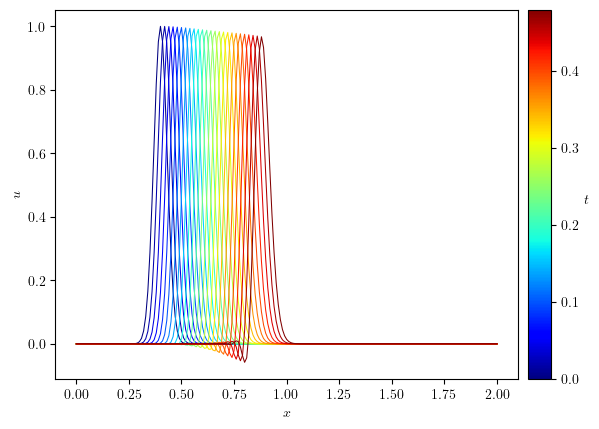

In [ ]:
results = simulation['u']
slc = slice(0, None, 2)
legend_labels=(min(results.time_series[slc]), max(results.time_series[slc]))
plot_line(results.series[slc], legend_labels, 't', cyc='jet', x_label='$x$', y_label=results.name)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$a$'>)

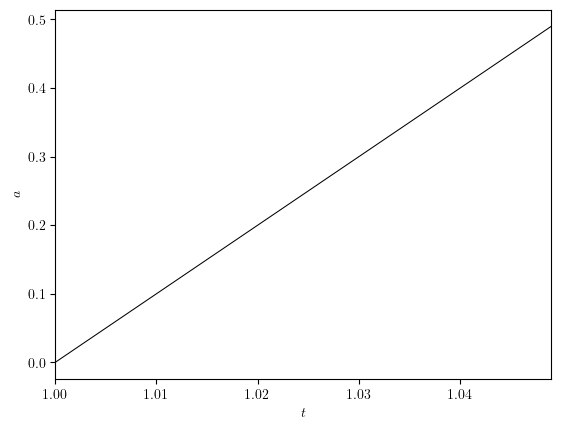

In [31]:
a = simulation['a']
ax = [i[0] for i in a.value_series]
plot_line((ax, a.time_series), x_label='t', y_label=a.name)

### $\mathcal{D}\in\{\text{CN}, \text{BE}, \text{AB}_2, \text{FE}\}$

In [ ]:
n_stop = 50
results: dict[FiniteDifference, FunctionSeries] = {}
for fdm in (CN, BE, FE, AB2):
    simulation = advection_simulation_1d(fdm)
    integrate(simulation, n_stop)
    results[fdm] = simulation['u']

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

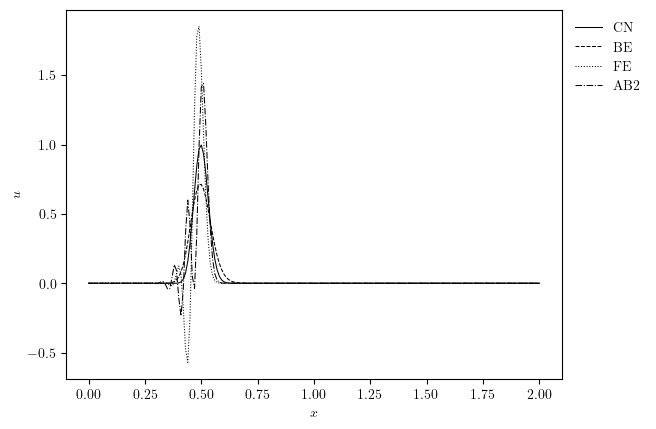

: 

In [ ]:
time_index = 10
legend_labels = list(results.keys())
plot_line([u.series[time_index] for u in results.values()], legend_labels, x_label='$x$', y_label='u')